In [1]:
!nvidia-smi

Sat Aug  3 14:01:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch # xây dựng mô hình và tính toán
import torchvision # sử dụng pretrained mô hình, chuẩn hoá, augment
import torchvision.transforms as transforms # chuẩn hóa và augment cũng như xử lí ảnh với torch
import torch.nn as nn # viết mô hình

In [3]:
# Chuẩn hóa dữ liệu
transform = transforms.Compose([
  # Chuyển sang dạng torch.Tensor của torch và đưa các giá trị về trong khoảng 0 và 1
  transforms.ToTensor(),  
  # Chuẩn hóa giá trị theo công thức của StandardScaler với mean = 0.5 và std = 0.5 --> x = (x_o - mean) / std
  transforms.Normalize((0.5,), (0.5,))
])

In [4]:
# Tải dữ liệu của pytorch
# Tập huấn luyện (train)
training_set = torchvision.datasets.MNIST(
    # đường dẫn đến nơi lưu dữ liệu
    './data',
    # tải bộ dữ liệu train
    train=True,
    # Thực hiện chuẩn hóa cho quá trình tải nếu có (nếu không để None)
    transform=transform,
    # thực hiện download xuống máy
    download=True
)
# Tập xác thực (validation)
validation_set = torchvision.datasets.MNIST(
    # đường dẫn đến nơi lưu dữ liệu
    './data',
    # tải bộ dữ liệu validation
    train=False,
    # thực hiện chuẩn hóa nếu có
    transform=transform,
    # tải bộ dữ liệu
    download=True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16479059.46it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 497238.26it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3887243.11it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4289693.49it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [1]:
# Tạo các dataloader phần này dùng để phục vụ việc huấn luyện mô hình với mini batch
# Nếu batch_size = 1 --> chính là phương pháp stochastic gradient descent (tức là chỉ cập nhật mô hình với 1 dữ liệu 1 step)
# Nếu batch_size = a < N (N số dữ liệu) --> chính là phương pháp mini batch
training_loader = torch.utils.data.DataLoader(
    # Tập dữ liệu
    training_set,
    # Kích cỡ batch size
    batch_size=4096,
    # Có tráo đổi dữ liệu không thường đối với việc huấn luyện ta nên để shuffle = True tránh việc huấn luyện bị lặp đi đi lăp lại liên tục
    # có thể tạo thành một pattern giúp mô hình học thuộc kết quả
    shuffle=True
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=4096,
    shuffle=False
)

NameError: name 'torch' is not defined

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Hiển thị một vài sample bức ảnh
def show_image(img: torch.Tensor):
  """
  Show các ảnh trong bộ dữ liệu
  Args:
    - img: ảnh ở dạng torch.Tensor
  """
  # do lúc tải dữ liệu xuống ta đã thực hiện normalize dữ liệu theo
  # công thức: (x - mean)/std --> do đó để hiển thị lại bức ảnh ta làm ngược lại là * 0.5 + 0.5
  img = img.mean(dim=0)
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(npimg, cmap="Greys")

Target:  tensor([9, 7, 1, 4, 6, 4, 9, 7, 0, 9, 8, 7, 0, 0, 2, 9, 0, 8, 7, 3, 4, 1, 4, 8,
        8, 5, 2, 7, 2, 5, 0, 1, 3, 1, 1, 7, 1, 4, 0, 9, 2, 9, 2, 7, 1, 6, 0, 1,
        6, 7, 7, 3, 7, 7, 4, 7, 6, 5, 5, 3, 6, 4, 4, 2])


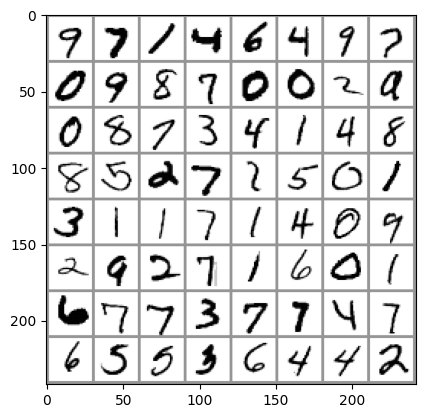

In [8]:
# Hiển thị 1 vài bức ảnh trong data
dataiter = iter(training_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)
show_image(img_grid)
print("Target: ", labels)

In [9]:
images[0].shape

torch.Size([1, 28, 28])

In [19]:
# Tạo mô hình NN với torch
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    # duỗi ảnh
    # với mạng NN nhận đầu vào là các vector 1d do đó ta phải duỗi ảnh từ 2d sang 1d để có thể dùng NN
    """
    1 2 3
    4 5 6

    Flatten --> 1 2 3 4 5 6
    """
    self.flatten = nn.Flatten()

    # định nghĩa layer đầu tiên đầu vào
    # nn.Linear: chính layer ở NN, đầu vào của nó là vector 1d có (d,)
    self.first_layer = nn.Linear(
        784, # in feature (số node đầu vào)
        256 # out feature (sô node đầu ra)
    )
    self.first_activation = nn.ReLU() # activation relu

    # ngoài việc phải viết từng phần như ở 2 câu lệnh trên ta có thể gom tất cả thành 1 khối với nn.Sequential
    self.second_layer = nn.Sequential(
        nn.Linear(256, 128),
        nn.ReLU()
    )

    self.output = nn.Sequential(
        # 10 class
        nn.Linear(128, 10),
        nn.Softmax(dim=-1)
        # nn.Sigmoid()
    )

  def forward(self, x):
    # quá trình forward của mô hình cho dữ liệu đi qua từng layer
    x = self.flatten(x)
    x = self.first_layer(x)
    x = self.first_activation(x)
    x = self.second_layer(x)
    x = self.output(x)
    return x

In [20]:
# kiểm tra thử
# tạo ngẫu nhiên đầu vào
# ảnh grayscale với kích thước 28 x 28
# 1, 1, 28, 28 = batch_size, channel, height, width
# 1, 128 = batch_size, d
# 1, 32, 3, 28, 28: batch_size, frame, channel, height, width
x = torch.randn(1, 1, 28, 28)
# khởi tạo mô hình
net = Net()

# thực hiện quá trình infer
net.eval()
with torch.no_grad():
  # khi viết thế này dòng code này chính là chạy hàm forward của net
  probs = net(x)

In [22]:
# ta có thể thấy đây chính là xác suất có thể là số nào từ 0 đến 9 của mô hình
print(probs)

tensor([[0.4660, 0.5511, 0.5233, 0.5127, 0.4704, 0.5189, 0.5021, 0.4969, 0.5689,
         0.5521]])


In [24]:
# Bắt đầu viết quá trình train
# khởi tạo hàm mất mát Cross Entropy và optimizer Adam (sẽ giải thích kĩ từng loại optimizer ở buổi thực hành)
net = Net()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [25]:
from tqdm import tqdm

In [26]:
# Viết quả trình train 1 epoch
# Mình có thể hiểu đơn giản là 1 epoch chính là mô hình hoàn thành 1 lần học trên toàn bộ data
# Mỗi step trong 1 epoch là mô hình học 1 phần nhỏ của dữ liệu

def train_one_epoch(epoch):
    total_loss = 0
    train_tqdm = tqdm(enumerate(training_loader), total=len(training_loader))

    # Với mỗi step huấn luyện mô hình
    for i, data in train_tqdm:
        # tách dữ liệu data thành hai phần đặc trưng và nhãn tương ứng
        inputs, labels = data

        # thực hiện quá trình forward
        outputs = net(inputs)

        # Tính toán mất mát
        loss = loss_fn(outputs, labels)

        # Khởi tạo gradient cho từng lần cập nhật ở mỗi step về 0
        optimizer.zero_grad()
        # tính toán gradient
        loss.backward()

        # Cập nhật weight
        optimizer.step()

        # Cộng với loss tổng
        total_loss += loss.item()

        # Cập nhật cho người dùng biết loss đang bao nhiêu
        train_tqdm.set_description(f"Epoch {epoch}: Total loss: {total_loss/(i + 1)}")

    return total_loss / len(training_loader)

In [27]:
num_epochs = 100
best_acc = 0

# với mỗi epoch
for epoch in range(1, num_epochs + 1, 1):

    # Chuyển mô hình sang quá trình train để cập nhật tham số
    net.train(True)
    train_loss = train_one_epoch(epoch)

    # eval model trên tập val
    preds = []
    gts = []

    # loại bỏ gradient cho quá trình inference
    net.eval()
    with torch.no_grad():
        # với mỗi batch dữ liệu trong tập val
        for i, data in enumerate(validation_loader):
            inputs, labels = data
            outputs = net(inputs)
            # do outputs là 1 list xác suất vào 10 số --> ta lấy vị trí lớn nhất trong array là dự đoán của mô hình
            # [0.9] + [0] * 8 + [0.1]
            # argmax = 0
            outputs = torch.argmax(outputs, dim=-1)

            # lưu các dữ liệu nhãn và dự đoán để tính acc
            print(labels.shape, outputs.shape)
            gts += labels.tolist()
            preds += outputs.tolist()

    # tính acc
    acc = torch.sum(
        torch.tensor(gts) == torch.tensor(preds)
    )/len(gts)

    print(f"Epoch {epoch}: Val acc = {acc}")

    # Lưu mô hình có acc tốt nhất
    if acc >= best_acc:
        best_acc = acc
        model_path = 'model_{}_{}'.format(epoch, acc)
        torch.save(net.state_dict(), model_path) # lưu mô hình

Epoch 1: Total loss: 1.740857914948006: 100%|██████████| 938/938 [00:22<00:00, 42.41it/s]


torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64

Epoch 2: Total loss: 1.5831659347733105:  87%|████████▋ | 815/938 [00:17<00:02, 46.06it/s]


KeyboardInterrupt: 

In [28]:
# Tải dữ liệu của pytorch
# Tập huấn luyện (train)
training_set = torchvision.datasets.CIFAR100(
    # đường dẫn đến nơi lưu dữ liệu
    './data',
    # tải bộ dữ liệu train
    train=True,
    # Thực hiện chuẩn hóa cho quá trình tải nếu có (nếu không để None)
    transform=transform,
    # thực hiện download xuống máy
    download=True
)
# Tập xác thực (validation)
validation_set = torchvision.datasets.CIFAR100(
    # đường dẫn đến nơi lưu dữ liệu
    './data',
    # tải bộ dữ liệu validation
    train=False,
    # thực hiện chuẩn hóa nếu có
    transform=transform,
    # tải bộ dữ liệu
    download=True
)

100%|██████████| 169001437/169001437 [00:03<00:00, 44222633.80it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# opencv
# torch
# tensorflow
#